In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
# set theme
plt.style.use('seaborn')
sns.set_style('darkgrid')

In [3]:
prices = pd.read_csv('vbr18_21.csv', index_col=0)
prices = prices.dropna(axis=1)
returns = np.log(prices).diff().dropna()

In [4]:
form_start = '2018-11-20'
form_end = '2020-05-19'
trade_start = '2021-05-20'
trade_end = '2021-11-19'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [5]:
'''
# Calculate Kendall's tau for each pair of stocks
results = pd.DataFrame(columns=['tau'])

for s1 in returns_form.columns:
    for s2 in returns_form.columns:
        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):
            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]
'''

"\n# Calculate Kendall's tau for each pair of stocks\nresults = pd.DataFrame(columns=['tau'])\n\nfor s1 in returns_form.columns:\n    for s2 in returns_form.columns:\n        if (s1!=s2) and (f'{s2}-{s1}' not in results.index):\n            results.loc[f'{s1}-{s2}'] = stats.kendalltau(returns_form[s1], returns_form[s2])[0]\n"

In [6]:
#results.to_csv('pairs_tau.csv')

In [7]:
results = pd.read_csv('pairs_tau.csv', index_col=0)

In [8]:
results.sort_values(by='tau')

,tau
WTRG-SWN,-0.054499
FLO-SWN,-0.050804
OVV-FLO,-0.045919
FLO-AR,-0.045274
BGS-WK,-0.041691
...,...
HOMB-CATY,0.725432
CFR-ASB,0.729228
CFR-BOKF,0.731751
MTG-RDN,0.738985


In [9]:
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

In [10]:
from statsmodels.tsa.stattools import coint

selected_stocks = []
selected_pairs = []
num_pairs = 25 # number of pairs to select

for pair in results.sort_values(by='tau', ascending=False).index:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        coint_pval = coint(prices_form[s1], prices_form[s2])[1] # ADF-test p-value
        if coint_pval<0.1: 
            selected_stocks.append(s1)
            selected_stocks.append(s2)
            selected_pairs.append(pair)
    
    if len(selected_pairs) == num_pairs:
        break

In [11]:
print(selected_pairs)

['CFR-ASB', 'HOMB-CATY', 'UMBF-FULT', 'HWC-BOKF', 'RDN-ESNT', 'EWBC-CMA', 'UBSI-TRMK', 'FRME-HTLF', 'NBTB-CHCO', 'UMPQ-FMBI', 'PBCT-STL', 'SFNC-FCF', 'AUB-TOWN', 'GBCI-CVBF', 'PACW-BKU', 'FNB-HOPE', 'ZION-PB', 'WAL-BOH', 'FFBC-GWB', 'ONB-UCBI', 'FRT-AKR', 'IBOC-FIBK', 'SHO-DRH', 'OGS-SR', 'DCI-LECO']


In [12]:
results.loc[selected_pairs]

,tau
CFR-ASB,0.729228
HOMB-CATY,0.725432
UMBF-FULT,0.709483
HWC-BOKF,0.698958
RDN-ESNT,0.696450
EWBC-CMA,0.695393
UBSI-TRMK,0.690483
FRME-HTLF,0.689640
NBTB-CHCO,0.687393
UMPQ-FMBI,0.681805


<AxesSubplot:>

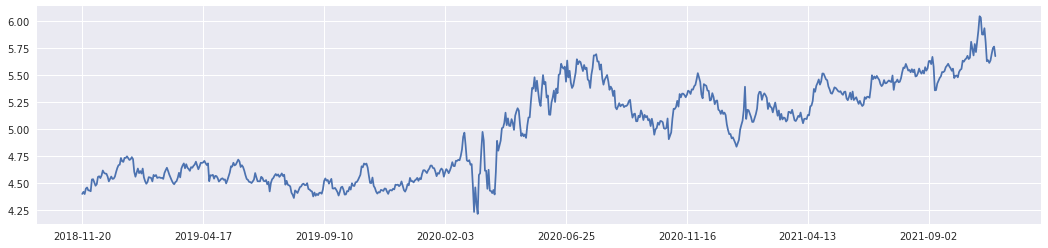

In [13]:
pair = 'CFR-ASB'
s1,s2 = parse_pair(pair)
spread = prices[s1]/prices[s2]

spread.plot(figsize=(18,4))

In [14]:
import statsmodels.api as sm

mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
res = mod.fit(search_reps=100)

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  756
Model:               MarkovRegression   Log Likelihood                 308.850
Date:                Sat, 23 Apr 2022   AIC                           -605.700
Time:                        19:45:11   BIC                           -577.932
Sample:                             0   HQIC                          -595.004
                                - 756                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3207      0.011    473.213      0.000       5.299       5.343
sigma2         0.0515      0.004     14.208      0.000       0.044       0.059
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5495      0.005    828.658      0.000       4.539       4.560
sigma2         0.0094      0.001     10.928      0.000       0.008       0.011
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9942      0.004    270.439      0.000       0.987       1.001
p[1->0]        0.0069      0.004      1.545      0.122      -0.002       0.016
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [16]:
res.expected_durations

array([172.64580843, 144.25831733])

In [17]:
res.params['const[0]']

5.320742762192855

In [18]:
res.params

p[0->0]      0.994208
p[1->0]      0.006932
const[0]     5.320743
const[1]     4.549452
sigma2[0]    0.051535
sigma2[1]    0.009386
dtype: float64

Text(0.5, 1.0, 'Probability of high-mean regime')

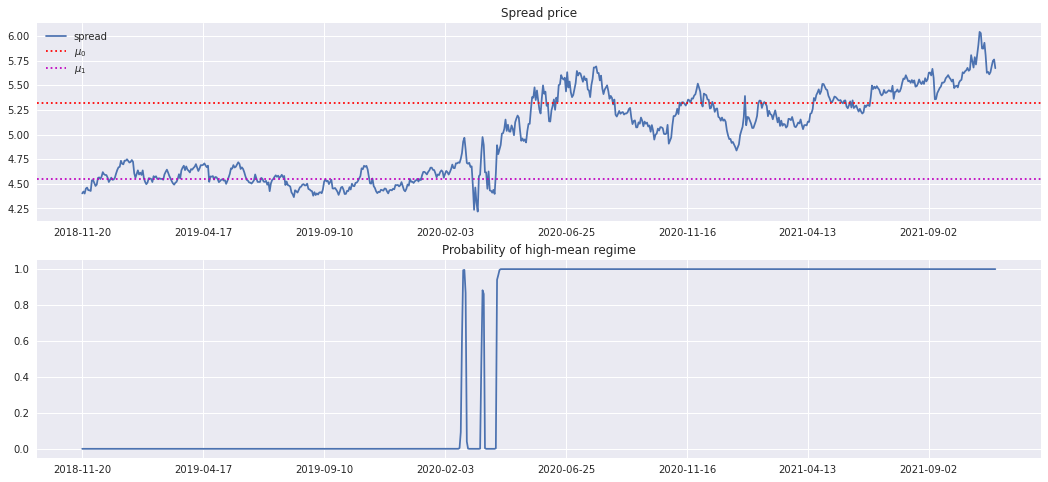

In [19]:
fig, axs = plt.subplots(2,1,figsize=(18,8))
spread.plot(ax=axs[0], label='spread')
axs[0].axhline(y=res.params['const[0]'], label=r'$\mu_0$', linestyle='dotted', c='r')
axs[0].axhline(y=res.params['const[1]'], label=r'$\mu_1$', linestyle='dotted', c='m')
axs[0].set_title('Spread price')
axs[0].legend()
res.smoothed_marginal_probabilities[0].plot(ax=axs[1])
axs[1].set_title('Probability of high-mean regime')

# Calculate markov regime switching parameters

In [24]:
'''
%%capture --no-display

markov_params = {}

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    
    markov_df = pd.DataFrame(index=prices_trade.index, columns=['prob_high', 'mu_high', 'sigma_high', 
                                                                'prob_low', 'mu_low', 'sigma_low'])

    for t in prices_trade.index:
        prices_tmp = prices.loc[:t]
        prices_tmp = prices_tmp.iloc[-250:] # 250 days trailing window
        spread = prices_tmp[s1] / prices_tmp[s2]

        # repeat until convergence
        converged = False
        while converged==False:
            mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)
            res = mod.fit(search_reps=100)
            if res.smoothed_marginal_probabilities[0][-1] > 0: # check if converged
                converged=True
                
        # determine index of high and low regimes
        if res.params['const[0]'] > res.params['const[1]']:
            high_reg = 0
            low_reg = 1
        else:
            high_reg = 1
            low_reg = 0
        
        # save regime parameters
        mu_high = res.params[f'const[{high_reg}]']
        sigma_high = np.sqrt(res.params[f'sigma2[{high_reg}]'])
        mu_low = res.params[f'const[{low_reg}]']
        sigma_low = np.sqrt(res.params[f'sigma2[{low_reg}]'])  

        prob_high = res.smoothed_marginal_probabilities[high_reg][-1]
        prob_low = res.smoothed_marginal_probabilities[low_reg][-1]

        markov_df.loc[t] = [prob_high, mu_high, sigma_high, prob_low, mu_low, sigma_low]
        
    markov_params[pair] = markov_df
'''

"\n%%capture --no-display\n\nmarkov_params = {}\n\nfor pair in selected_pairs:\n    s1,s2 = parse_pair(pair)\n    \n    markov_df = pd.DataFrame(index=prices_trade.index, columns=['prob_high', 'mu_high', 'sigma_high', \n                                                                'prob_low', 'mu_low', 'sigma_low'])\n\n    for t in prices_trade.index:\n        prices_tmp = prices.loc[:t]\n        prices_tmp = prices_tmp.iloc[-250:] # 250 days trailing window\n        spread = prices_tmp[s1] / prices_tmp[s2]\n\n        # repeat until convergence\n        converged = False\n        while converged==False:\n            mod = sm.tsa.MarkovRegression(spread, k_regimes=2, switching_variance=True)\n            res = mod.fit(search_reps=100)\n            if res.smoothed_marginal_probabilities[0][-1] > 0: # check if converged\n                converged=True\n                \n        # determine index of high and low regimes\n        if res.params['const[0]'] > res.params['const[1]']:\n      

In [25]:
import pickle

In [26]:
#pickle.dump(markov_params, open('markov_params.p', 'wb'))

In [27]:
markov_params = pickle.load(open('markov_params.p', 'rb'))

# Calculate returns of each pair

In [28]:
delta = 1.645
rho = 0.7

algo_returns = pd.DataFrame(index=prices_trade.index, columns=selected_pairs)

for pair in selected_pairs:
    s1,s2 = parse_pair(pair)
    spread = prices_trade[s1] / prices_trade[s2]
    
    # calculate positions
    positions = pd.DataFrame(index=prices_trade.index, columns=[s1,s2])
    markov_df = markov_params[pair]
    condition_short_high = (spread > markov_df['mu_high'] + delta * markov_df['sigma_high'])
    positions[condition_short_high] = [-1,1]

    condition_long_high = ((spread < markov_df['mu_high'] - delta * markov_df['sigma_high']) & 
                           (markov_df['prob_high'] > rho))
    positions[condition_long_high] = [1,-1]

    condition_short_low = ((spread > markov_df['mu_low'] + delta * markov_df['sigma_low']) & 
                           (markov_df['prob_low'] > rho))
    positions[condition_short_low] = [-1,1]

    condition_long_low = (spread < markov_df['mu_low'] - delta * markov_df['sigma_low'])
    positions[condition_long_low] = [1,-1]

    positions = positions.fillna(0)
    
    # calculate returns
    ret = (positions.shift() * returns_trade[[s1,s2]]).sum(axis=1) * 2 # double capital (from short positions)
    algo_returns[pair] = ret

In [29]:
algo_simple_ret = np.exp(algo_returns)-1 # transform log-returns to simple returns

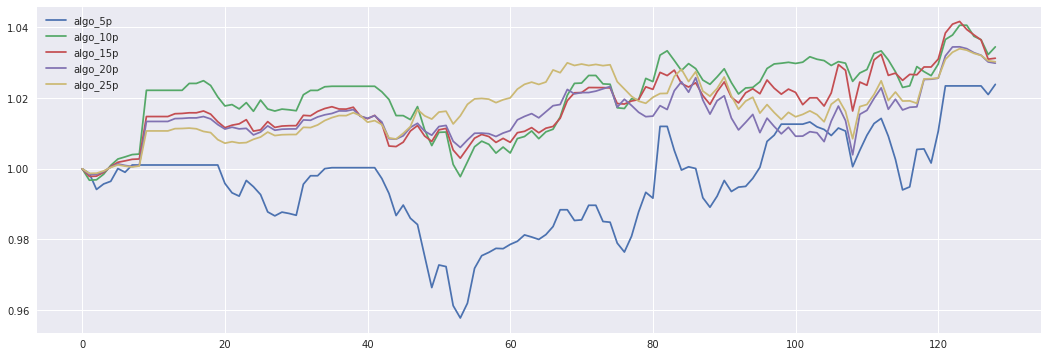

In [30]:
algo_cumret = {}

for num_pairs in [5,10,15,20,25]:
    algo_cumret[f'{num_pairs}p'] = np.nancumprod(algo_simple_ret[selected_pairs[:num_pairs]].sum(axis=1) 
                                                 / num_pairs + 1)
    
plt.figure(figsize=(18,6))
for k in algo_cumret.keys():
    plt.plot(algo_cumret[k], label=f'algo_{k}')
plt.legend()

[*********************100%***********************]  1 of 1 completed


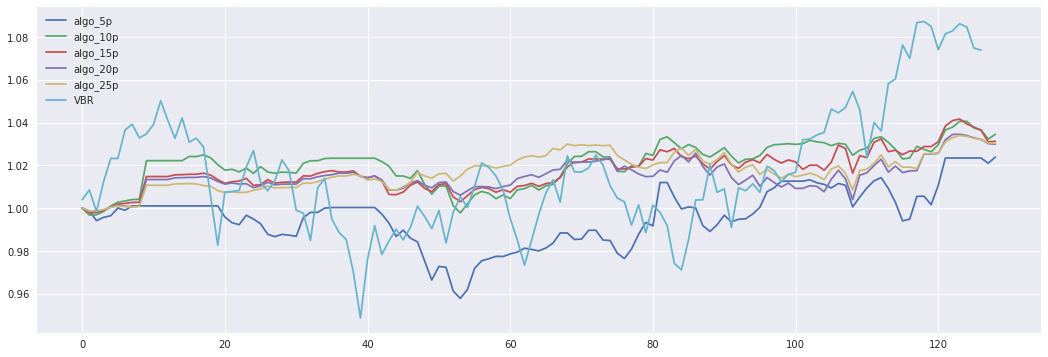

In [31]:
import yfinance as yf
vbr_price = yf.download('VBR', start=trade_start, end=trade_end)
vbr_price = vbr_price['Adj Close']
vbr_cumret = np.nancumprod(vbr_price.pct_change().dropna()+1)

plt.figure(figsize=(18,6))
for k in algo_cumret.keys():
    plt.plot(algo_cumret[k], label=f'algo_{k}')
plt.plot(vbr_cumret, label='VBR')
plt.legend()

In [32]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [33]:
metrics = pd.DataFrame(index=algo_cumret.keys(), columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
for k in algo_cumret.keys():
    metrics.loc[k] = calculate_metrics(algo_cumret[k])
metrics.loc['VBR'] = calculate_metrics(vbr_cumret)

In [34]:
metrics

,Total return,APR,Sharpe,MaxDD,MaxDDD
5p,0.023898,0.047216,0.7079,-0.043246,61.0
10p,0.034514,0.068532,1.39197,-0.026497,53.0
15p,0.031296,0.062049,1.363946,-0.014315,32.0
20p,0.029901,0.059243,1.284509,-0.021276,34.0
25p,0.030299,0.060044,1.526861,-0.020863,52.0
VBR,0.069689,0.143021,0.867726,-0.096744,96.0
